In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
T = 100000  # horizon
K = 5  # number of arms
N_EXPERIMENTS = 10  # number of experiments

# Range of means and variances
mean_min = 0
mean_max = 1
variance_min = 1.1  # avoid 1-subgaussian
variance_max = 5

In [12]:
# Random means and variances
means = []
variances = []
for a in range(K):
    means.append(np.random.uniform(mean_min, mean_max))
    variances.append(np.random.uniform(variance_min, variance_max))
best_arm = np.argmax(means)  # index of arm with max mean

print("Randomly generated means:", means)
print("Randomly generated variances:", variances)
print("Best arm index:", best_arm)
print("Best arm mean:", means[best_arm])

Randomly generated means: [0.6094329982425694, 0.4562148606702807, 0.8546591318159567, 0.34727319077739127, 0.5196986569693045]
Randomly generated variances: [1.8041672570211524, 4.315180390750729, 2.2510964194688916, 4.888155330785039, 1.4032747841937925]
Best arm index: 2
Best arm mean: 0.8546591318159567


In [13]:
# Known variance UCB
def known_variance_ucb(means, variances, best_arm):
    counts = np.zeros(K)  # counts how many times each arm is pulled, initialized to 0
    emp_means = np.zeros(K)  # empirical means of each arm
    regret = np.zeros(T + 1)  # cumulative regret up to round t, initialized to 0

    for t in range(1, T + 1):
        # Select arm
        ucb_values = []
        for a in range(K):
            if counts[a] == 0:
                ucb_values.append(np.inf)
            else:
                ucb_values.append(emp_means[a] + np.sqrt((4 * variances[a] * np.log(T)) / counts[a]))
        arm = np.argmax(ucb_values)  # index of arm with max ucb

        # Pull arm
        reward = np.random.normal(loc=means[arm], scale=np.sqrt(variances[arm]))

        # Update
        counts[arm] += 1
        emp_means[arm] += (reward - emp_means[arm]) / counts[arm]
        regret[t] = regret[t - 1] + (means[best_arm] - means[arm])

    return regret

In [14]:
def unknown_variance_ucb(means, variances, best_arm):
    counts = np.zeros(K)
    emp_means = np.zeros(K)
    emp_variances = np.ones(K)  # emperical variances of each arm, initialized to 1 (safe to be empty, but compiler might complain)
    regret = np.zeros(T + 1)

    for t in range(1, T + 1):
        # Select arm
        ucb_values = []
        for a in range(K):
            if counts[a] == 0:
                ucb_values.append(np.inf)
            else:
                ucb_values.append(emp_means[a] + np.sqrt((4 * emp_variances[a] * np.log(T)) / counts[a]))
        arm = np.argmax(ucb_values)  # index of arm with max ucb

        # Pull arm
        reward = np.random.normal(loc=means[arm], scale=np.sqrt(variances[arm]))

        # Update
        counts[arm] += 1
        emp_means[arm] += (reward - emp_means[arm]) / counts[arm]
        if counts[arm] > 1:
            # Update empirical variance
            emp_variances[arm] = np.var(np.random.normal(means[arm], np.sqrt(variances[arm]), int(counts[arm])))
        regret[t] = regret[t - 1] + (means[best_arm] - means[arm])

    return regret

In [15]:
# Experiments
known_variance_regrets = np.empty((N_EXPERIMENTS, T + 1))
unknown_variance_regrets = np.empty((N_EXPERIMENTS, T + 1))

for i in range(N_EXPERIMENTS):
    known_variance_regrets[i] = known_variance_ucb(means, variances, best_arm)
    unknown_variance_regrets[i] = unknown_variance_ucb(means, variances, best_arm)

# Mean and Std Dev
known_variance_regrets_avg = np.mean(known_variance_regrets, axis=0)
known_variance_regrets_std = np.std(known_variance_regrets, axis=0)

unknown_variance_regrets_avg = np.mean(unknown_variance_regrets, axis=0)
unknown_variance_regrets_std = np.std(unknown_variance_regrets, axis=0)

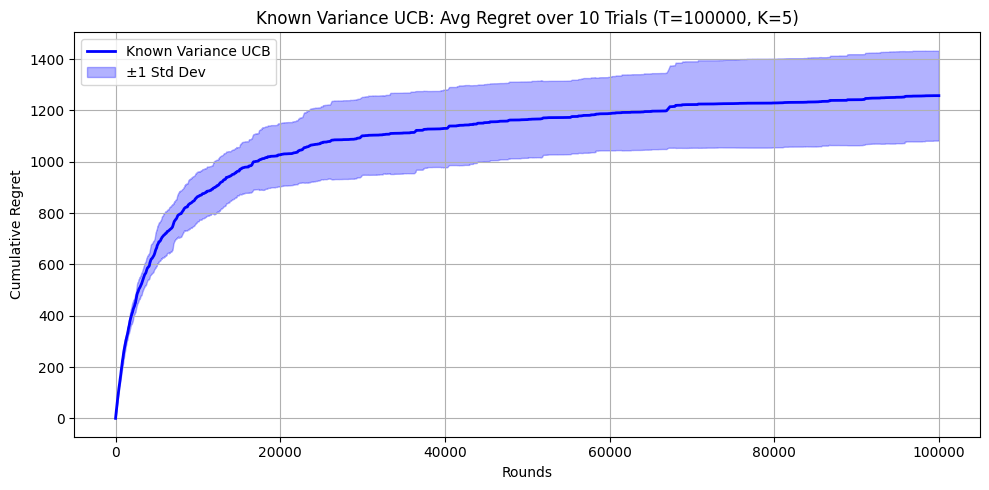

In [16]:
# Plot: Known Variance UCB
plt.figure(figsize=(10, 5))
plt.plot(known_variance_regrets_avg, label="Known Variance UCB", color="blue", linewidth=2)
plt.fill_between(
    range(T + 1),
    known_variance_regrets_avg - known_variance_regrets_std,
    known_variance_regrets_avg + known_variance_regrets_std,
    color="blue",
    alpha=0.3,
    label="±1 Std Dev"
)
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.title(f"Known Variance UCB: Avg Regret over {N_EXPERIMENTS} Trials (T={T}, K={K})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

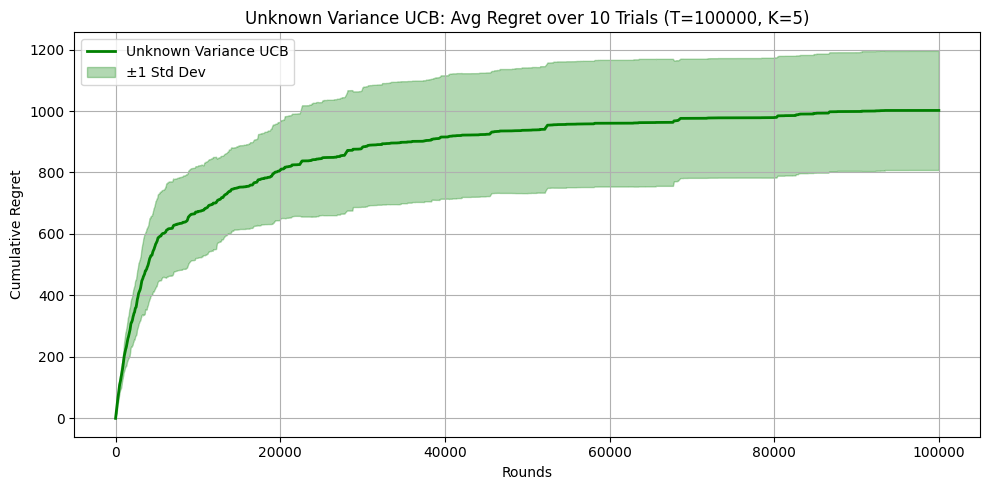

In [17]:
# Plot: Unknown Variance UCB
plt.figure(figsize=(10, 5))
plt.plot(unknown_variance_regrets_avg, label="Unknown Variance UCB", color="green", linewidth=2)
plt.fill_between(
    range(T + 1),
    unknown_variance_regrets_avg - unknown_variance_regrets_std,
    unknown_variance_regrets_avg + unknown_variance_regrets_std,
    color="green",
    alpha=0.3,
    label="±1 Std Dev"
)
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.title(f"Unknown Variance UCB: Avg Regret over {N_EXPERIMENTS} Trials (T={T}, K={K})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()